<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/DynANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### settings & clone github

In [1]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # clone github
# !git clone https://github.com/katduecker/dnn_osci

# # enter folder
# %cd dnn_osci

%cd aet_pytorch/

import os

fig_pth = "/Users/katharinaduecker/Documents/projects_uob/dyn_ann/plos comp biol/figures/noise/"

if not os.path.isdir(fig_pth):
    os.mkdir(fig_pth)


load_NN = True  # load pre-trained NN? - note that the parameters defining the dynamics have to be adapted for newly trained networks
save_NN = True # save trained NN?
add_noise = 0.3

/Users/katharinaduecker/Documents/projects_uob/dyn_ann/dnn_osci/aet_pytorch


In [2]:
# import packages

import torch
from torch import nn
import numpy as np

# get CUDA index
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# colours for plot
col = mcolors.TABLEAU_COLORS

from itertools import combinations

import scipy

from matplotlib.patches import Rectangle


import aet_net_2lay  # 2-layer architecture
from aet_net import sigmoid
from aet_dyn import euler_dyn, euler_dyn_2layer, fun_fixed_point_num


from scipy.optimize import fsolve
import scipy

## Concept figure

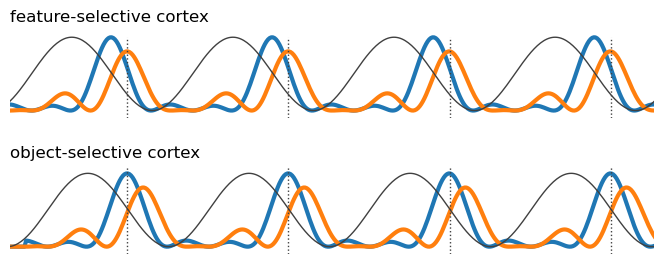

In [3]:
## Concept figure 1

from aet_figures import fig1

fig_1 = fig1()

## Train or load network

In [4]:
nn_dim_ = [
    28,
    64,
    32,
    3,
]  # [quadrant size, number of hidden nodes, number of output nodes]
mini_sz_ = 1 # mini batch size (1 = use SGD)

if add_noise == True:
    num_epo_ = 20
    eta_ = 1e-4  # learning rate

else:
    num_epo_ = 30
    eta_ = 4e-4  # learning rate

sig_param = [
    [2, -2.5, False],
    [2, -2.5, False],
]  # sigmoid slope and shift in x direction


# sparsity and orthogonality parameters not used in publication
beta_ = 0
p_ = 0.1  # has to be != 0 even if not used
kl_reg_ = [
    beta_,
    p_,
    1,
]  
ortho_lmbda = 0
ortho_layer = 1

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [
    nn.CrossEntropyLoss(),
    nn.Softmax(dim=-1),
]

params = nn_dim_, eta_, mini_sz_, num_epo_, kl_reg_, sig_param, ortho_lmbda, ortho_layer


if load_NN and add_noise:
    model = torch.load("model_2layer_noise.pt")
    loss_hist = torch.load("loss_epoch_noise.pt")
elif load_NN and add_noise == False:
    model = torch.load("model_2layer.pt")
    loss_hist = torch.load("loss_epoch.pt")

else:

    # initialize model and weights
    model = aet_net_2lay.net(params, lossfun)
    model = aet_net_2lay.init_params(model, weight_init="uni")

    optimizer = torch.optim.Adam(model.parameters(), lr=eta_)

    model.to(DEVICE)
    loss_hist = model.train(optimizer, noise=add_noise, print_loss=True)


if save_NN and add_noise:
    torch.save(model, "model_2layer_noise.pt")
    torch.save(loss_hist, "loss_epoch_noise.pt")

elif save_NN and add_noise == False:
    torch.save(model, "model_2layer.pt")
    torch.save(loss_hist, "loss_epoch.pt")

In [5]:
# for manuscript: check range of noise
noise_example = torch.normal(0.4,0.1,(56,56))*0.3
torch.min(noise_example),torch.max(noise_example)

# check size of training set
x_test, y_test = aet_net_2lay.aet_stim.mkstim(noise=add_noise, num_it=10)
x_test.shape

# loss
loss_hist[-1]

tensor(0.5627, grad_fn=<SelectBackward0>)

In [6]:
# create test set
x_test, y_test = aet_net_2lay.aet_stim.mkstim(noise=add_noise, num_it=0)
x_test = x_test.to(DEVICE)
y_test = y_test.to(DEVICE)

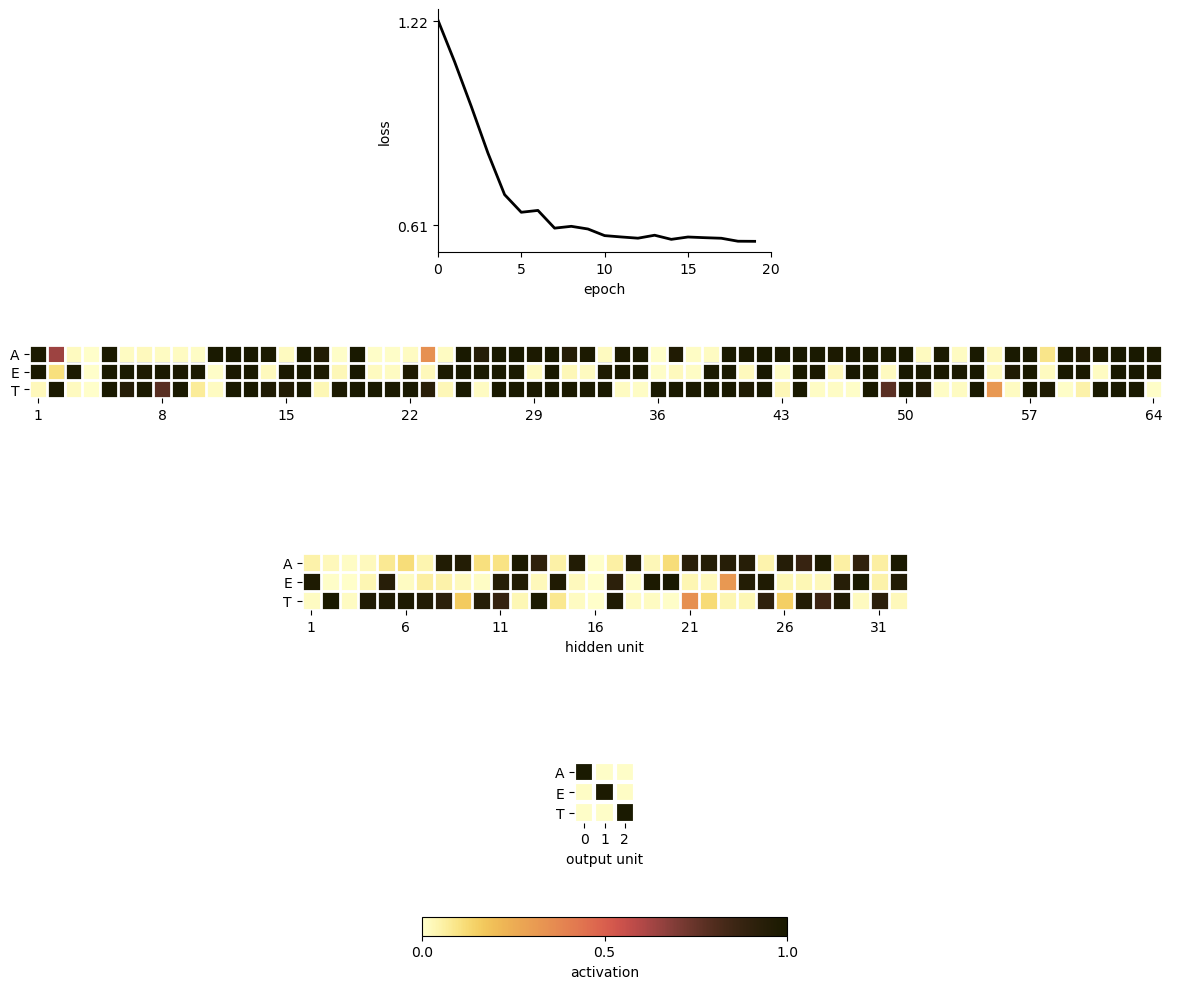

In [7]:
# plot network activations

Z21, H21, H22, O2 = model.forw_conv(
    x_test
)  # get the hidden layer activations for plotting

# inputs
loss_hist = loss_hist.detach().cpu()
from aet_figures import fig2

# prepare labels
idx = np.array((0, 4, 8))
label = ["A", "E", "T"]

fig_2 = fig2(loss_hist, idx, label, H21, H22, O2)
fig_2.savefig(fig_pth + "fig2_acti_loss.svg")

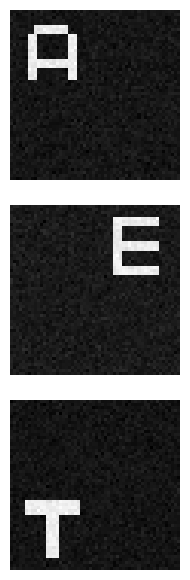

In [8]:
idx = np.array((0, 5, 10))  # ,-1))
fig, axs = plt.subplots(3, 1, figsize=(2, 6))

for i, ii in enumerate(idx):
    inpt = x_test[ii]
    axs[i].imshow(inpt.reshape(56, 56), cmap="gray")
    axs[i].set_axis_off()

fig.tight_layout()

fig.savefig(fig_pth + "stim_with_noise.svg")

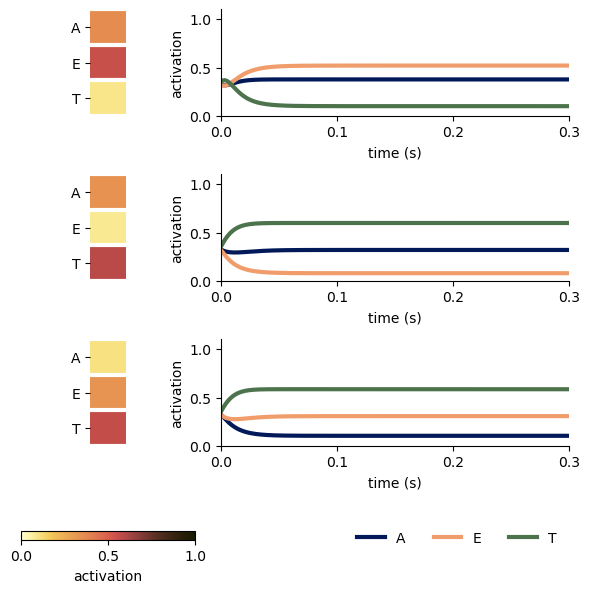

In [9]:
# show how it fails when presented with two stimuli

from aet_figures import fig5

idx = np.array((0, 5, 10))  # ,-1))
inp_combi = list(combinations(idx, 2))
label = ["A", "E", "T"]
fig_5, inpt = fig5(x_test, model, idx, label)

fig_5.savefig(fig_pth + "fig5_bottleneck.svg")

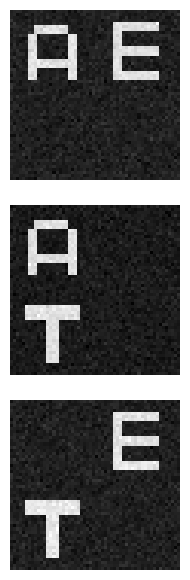

In [10]:
# bottleneck inputs
inpt = [None] * 3
inp_combi = list(combinations(idx, 2))  # possible combinations
fig, axs = plt.subplots(3, 1, figsize=(2, 6))
for i, comp_inp in enumerate(inp_combi):

    inpt = x_test[comp_inp[0]] + x_test[comp_inp[1]]

    axs[i].imshow(inpt.reshape(56, 56), cmap="gray")
    axs[i].set_axis_off()

fig.tight_layout()

fig.savefig(fig_pth + "fig5_stim.svg")

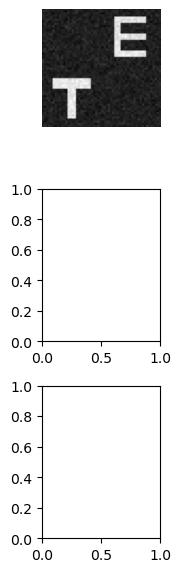

In [11]:
# plot stimulus examples
fig, axs = plt.subplots(3, 1, figsize=(2, 6))

for i, _im in enumerate(inpt):
    axs[i].imshow(_im.reshape(56, 56), cmap="gray")
    axs[i].set_axis_off()

fig.tight_layout()

fig.savefig(fig_pth + "bottleneck_stim.svg")

## Explore parameters c & S

In [12]:
# # prepare colormaps and layout
# from cmcrameri import cm
# step_cm = int(len(cm.lajolla_r.colors) / (Z+1))
# cmz = cm.lajolla_r.colors[0 : len(cm.lajolla_r.colors) : step_cm]
# Z_vec

/Users/katharinaduecker/miniconda3/envs/aet_nn/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katharinaduecker/miniconda3/envs/aet_nn/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katharinaduecker/Documents/projects_uob/dyn_ann/dnn_osci/aet_pytorch/aet_net.py:18: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-_slope * (z + _bias)))


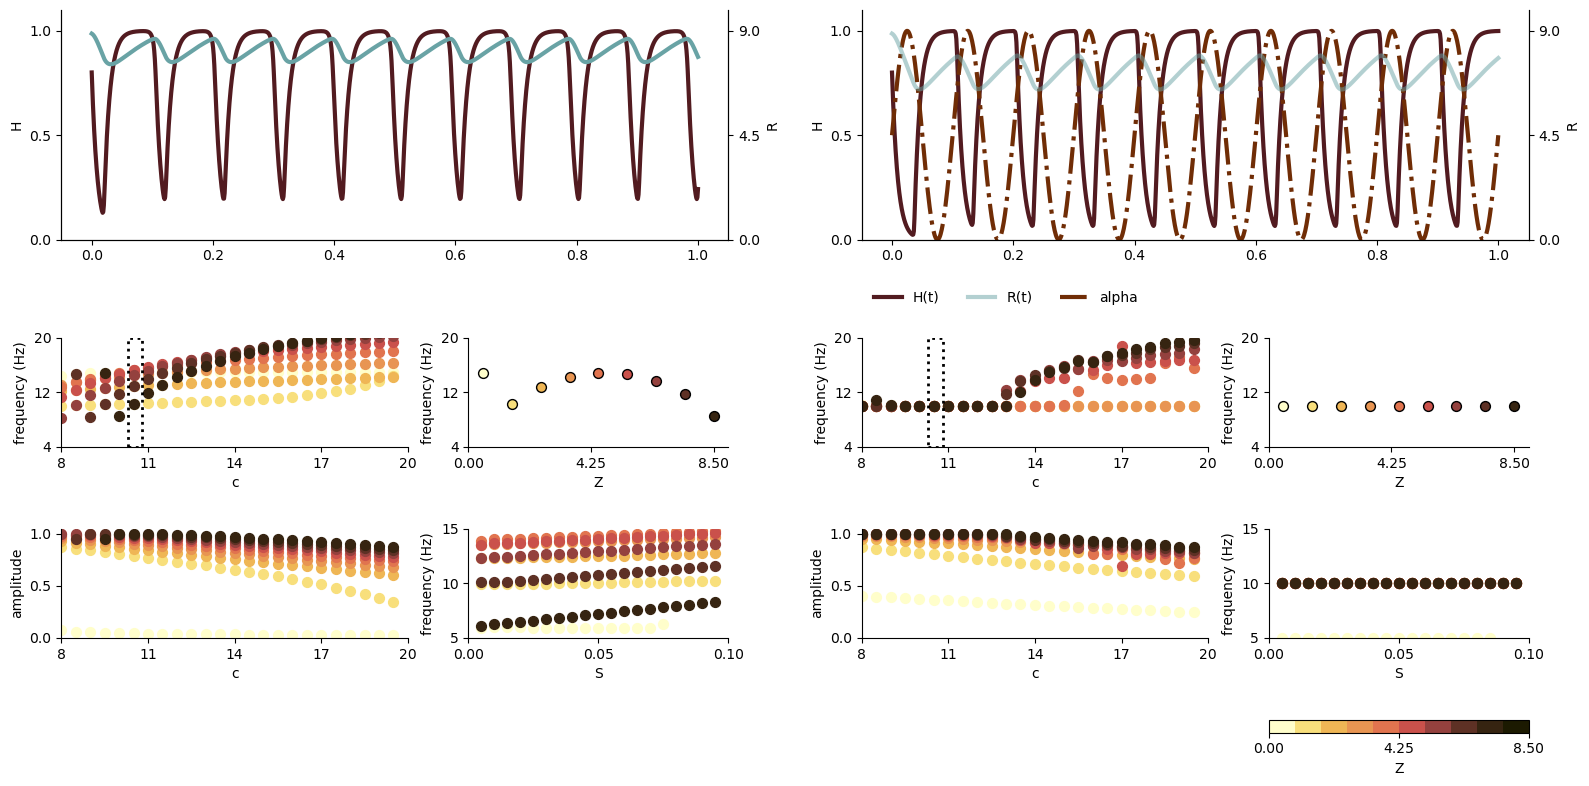

In [13]:
from aet_figures import fig3

# get all Z's for all inputs
Zall = model.forw_conv(x_test)[0]

# find maximum
Z = np.ceil(torch.max(Zall[:]).detach().numpy())

Z_vec = np.arange(0.5, Z + 1, 1)

# dynamics parameters
tau_h = 0.01
tau_R = 0.1
a = 2
S = 0.1
# fix c
c = 10

params = [tau_h, tau_R, c, S]

# explore range of values for c and S depending on activation Z
c_vec = np.arange(Z, 2.5 * Z, 0.5)
S_vec = np.arange(0.005, 0.1, 0.005)

# parameters for inhibition ogg
alpha_freq = 10
alpha_amp = 0
alpha_phs = 0
alpha_params_off = [alpha_freq, alpha_amp, alpha_phs]

# parameters for inhibition on
alpha_amp = 0.6
alpha_params_on = [alpha_freq, alpha_amp, alpha_phs]

fig_3, peaks_r, troughs_r = fig3(
    Z, Z_vec, c_vec, S_vec, params, alpha_params_off, alpha_params_on
)

fig_3.savefig(fig_pth + "fig3_explore_param.svg")

# mean_rise_r = np.mean(troughs_r[:-1] - peaks_r)     # mean rise time of R with this combination of tau_R and c

In [14]:
sigmoid(1.7,sig_param[0][:-1])

0.16798161486607552

## Dynamics single input

start dynamics at fixed points for Z = maxZ/2

$R = \frac{c}{c-1}Z$ and
$H = \frac{Z}{c-1}$

In [15]:
# get all hidden activations without dynamics

Z21, H1, H2, O = model.forw_conv(x_test[0])
Z22 = model.fc1(H1)
H1 = H1.detach().cpu().numpy()
H2 = H2.detach().cpu().numpy()
O = O.detach().cpu().numpy()

In [16]:
# Dynamics parameters
tau_h = 0.01
tau_R = 0.1
S = 0.1
# fix c
c = 10

t_start = 0  # when stimulus presented
t = 0  # when to begin plot

params = [tau_h, tau_R, c, S]

In [17]:
## Dynamics one input

## without alpha inhibition
# alpha parameters
afreq = [10, 10]
aamp = [0, 0]
aph = [np.pi / 2, np.pi / 2]

alpha_params = [afreq, aamp, aph]

timevec = np.linspace(0, 1, 1000)

maxZ = np.ceil(torch.max(Zall[:]).detach().numpy())

start_fix_z = maxZ / 3

# get time course of Z (pre-activation), H, R, and O (output)
Z1t, Z2t, H1t, R1t, H2t, R2t, Ot = euler_dyn_2layer(
    model,
    x_test[0],
    params,
    timevec,
    alpha_params,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)

## with alpha inhibition
# alpha parameters
afreq = [10, 10]
aamp = [0.5, 0.5]

alpha_params = [afreq, aamp, aph]

timevec = np.linspace(0, 1, 1000)

# get time course of Z (pre-activation), H, R, and O (output)
# with alpha inhibition
Z1ta, Z2ta, H1ta, R1ta, H2ta, R2ta, Ota = euler_dyn_2layer(
    model,
    x_test[0],
    params,
    timevec,
    alpha_params,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)


# find fixed points numerically

# layer 1
Z = Z21.detach().cpu()

Hstar1 = np.zeros_like(Z)
Rstar1 = np.zeros_like(Z)
for i, z in enumerate(Z):
    # fixed point
    Hstar1[i] = fsolve(fun_fixed_point_num, 0.001, args=(z, c, S))[0]
    Rstar1[i] = c * Hstar1[i]

# layer 2
Z = Z22.detach().cpu()

# the fixed points for alpha are not stable
Hstar2 = np.zeros_like(Z)
Rstar2 = np.zeros_like(Z)
for i, z in enumerate(Z):
    # fixed point
    Hstar2[i] = fsolve(fun_fixed_point_num, 0.001, args=(z, c, S))[0]
    Rstar2[i] = c * Hstar2[i]

/Users/katharinaduecker/Documents/projects_uob/dyn_ann/dnn_osci/aet_pytorch/aet_dyn.py:161: RuntimeWarning: invalid value encountered in log
  return (Z / (c - 1)) + (S / (c - 1)) * (np.log(1 / x - 1) / 2 - 2.5) - x
/var/folders/7z/wfcp96210zb700801j0vcbmw0000gn/T/ipykernel_72946/2427069760.py:61: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Hstar1[i] = fsolve(fun_fixed_point_num, 0.001, args=(z, c, S))[0]
/var/folders/7z/wfcp96210zb700801j0vcbmw0000gn/T/ipykernel_72946/2427069760.py:72: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Hstar2[i] = fsolve(fun_fixed_point_num, 0.001, args=(z, c, S))[0]


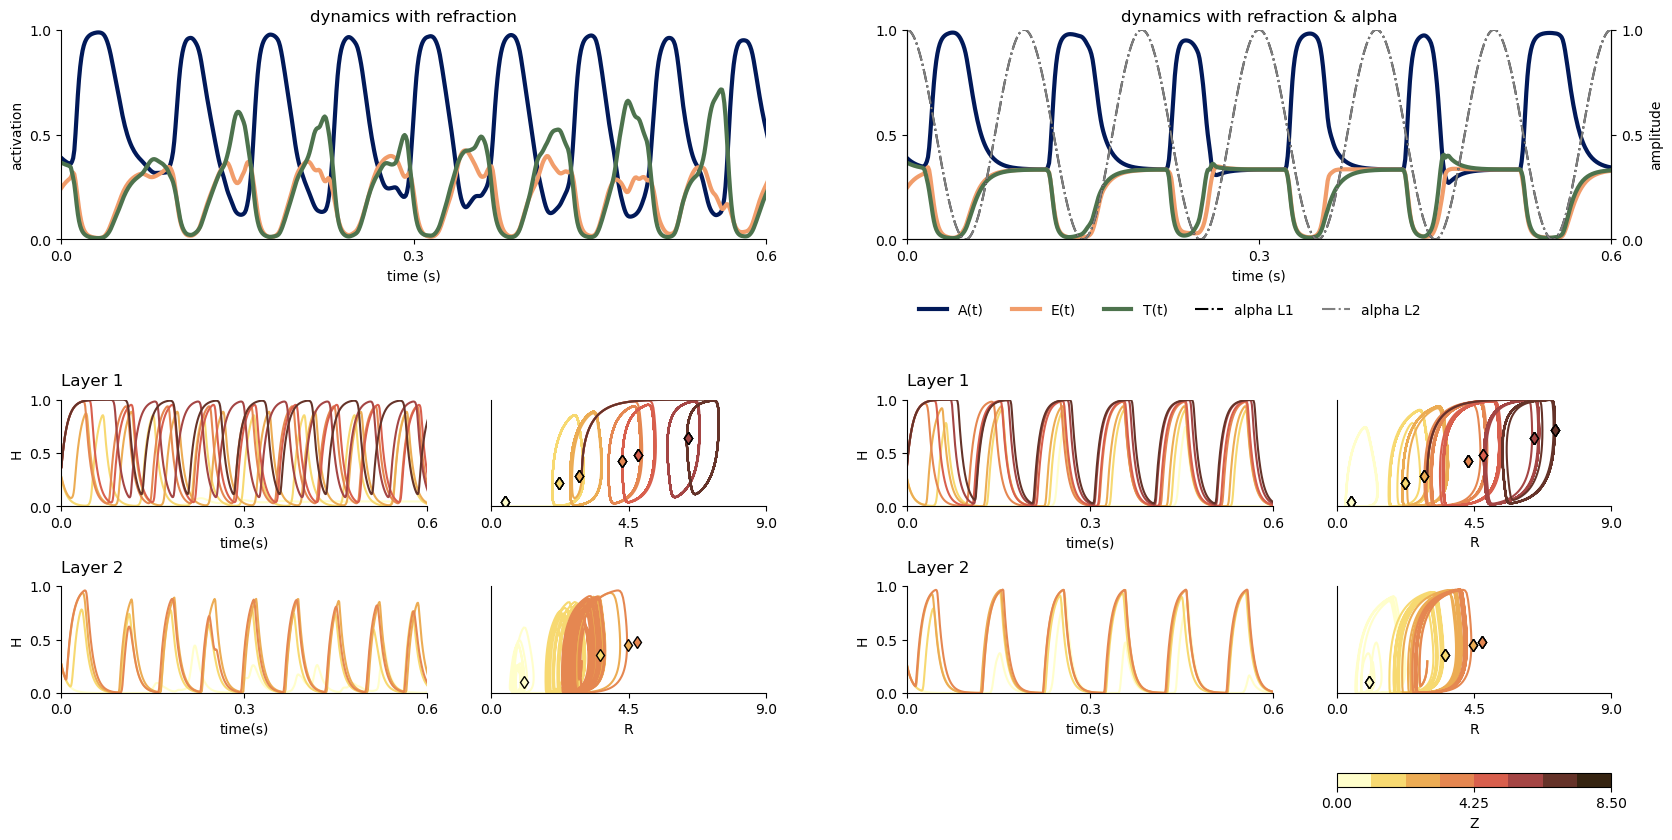

In [18]:
# plot
from aet_figures import fig4

fig_4 = fig4(
    timevec,
    alpha_params,
    t_start,
    x_test,
    model,
    Z21,
    Z22,
    H1t,
    Hstar1,
    H1ta,
    H2t,
    H2ta,
    Hstar2,
    R1t,
    Rstar1,
    R1ta,
    R2t,
    R2ta,
    Rstar2,
    Ot,
    Ota,
)

fig_4.savefig(fig_pth + "fig4_dyn_one_inp.svg")

In [19]:
# Dynamics parameters
tau_h = 0.01
tau_R = 0.1
S = 0.1
# fix c
c = 10

t_start = 0  # when stimulus presented
t = 0  # when to begin plot

params = [tau_h, tau_R, c, S]

In [20]:
x_test, y_test = aet_net_2lay.aet_stim.mkstim(noise=False)
x_test = x_test.to(DEVICE)

## Dynamics two inputs

In [21]:
# parameters for integration
timevec = np.linspace(0, 1, 1000)

t_start = 0  # when stimulus presented
t = 0  # when to begin plot
start_fix_z = maxZ / 4

params = [tau_h, tau_R, c, S]

inpt = [None] * 3
# E & A

inpt[0] = x_test[5] * 0.8 + x_test[0] * 1.2 + torch.normal(0.4, 0.1, x_test[5].shape) * add_noise
inpt[0] /= torch.max(inpt[0])
# without alpha
aamp = [0, 0]
aph = [np.pi / 2, np.pi / 2]  # phase lag = 0 between layers

alpha_params = [afreq, aamp, aph]

# time course of output for E & A
OtEA = euler_dyn_2layer(
    model,
    inpt[0],
    params,
    timevec,
    alpha_params,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)[-1]

# with alpha
aamp = [0.5, 0.5]

alpha_params = [afreq, aamp, aph]

OtaEA = euler_dyn_2layer(
    model,
    inpt[0],
    params,
    timevec,
    alpha_params,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)[-1]

# E & T

inpt[1] = x_test[6] * 1.2 + x_test[-1] * 0.8 + torch.normal(0.4, 0.1, x_test[5].shape) * add_noise
inpt[1] /= torch.max(inpt[1])

# without alpha
aamp = [0, 0]


alpha_params = [afreq, aamp, aph]

OtET = euler_dyn_2layer(
    model,
    inpt[1],
    params,
    timevec,
    alpha_params,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)[-1]


# with alpha
aamp = [0.5, 0.5]


alpha_params = [afreq, aamp, aph]

OtaET = euler_dyn_2layer(
    model,
    inpt[1],
    params,
    timevec,
    alpha_params,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)[-1]

# A & T

inpt[2] = x_test[1] * 1.2 + x_test[-2] * 0.8 + torch.normal(0.4, 0.1, x_test[5].shape) * add_noise
inpt[2] /= torch.max(inpt[2])

# without alpha
aamp = [0, 0]

alpha_params = [afreq, aamp, aph]

OtAT = euler_dyn_2layer(
    model,
    inpt[2],
    params,
    timevec,
    alpha_params,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)[-1]


# with alpha
aamp = [0.5, 0.5]


alpha_params = [afreq, aamp, aph]

OtaAT = euler_dyn_2layer(
    model,
    inpt[2],
    params,
    timevec,
    alpha_params,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)[-1]

In [22]:
# find period of activation in output (-> corresponds to visual gamma oscillations)
slope_sign = np.sign(np.diff(OtaEA[0][np.where((OtaEA[0].numpy() >= 0.4))]))

first_half = []
second_half = []
for i, s in enumerate(slope_sign[:-1]):
    if s == 1 and slope_sign[i + 1] == -1:
        first_half.append(i)
    if s == -1 and slope_sign[i + 1] == 1:
        second_half.append(i)

len_diff = len(first_half) - len(second_half)

if len_diff > 0:
    h = np.array(first_half[0])
    sh = np.array(second_half)
    fh = np.array(first_half[:-len_diff])
elif len_diff < 0:
    h = np.array(second_half[0])
    sh = np.array(first_half)
    fh = np.array(second_half[:-np.abs(len_diff)])
elif len_diff == 0:
    h = np.array(first_half[0])
    sh = np.array(second_half)
    fh = np.array(first_half)

l_period_activation = sh - fh + h

m_period = np.mean(l_period_activation[1:])

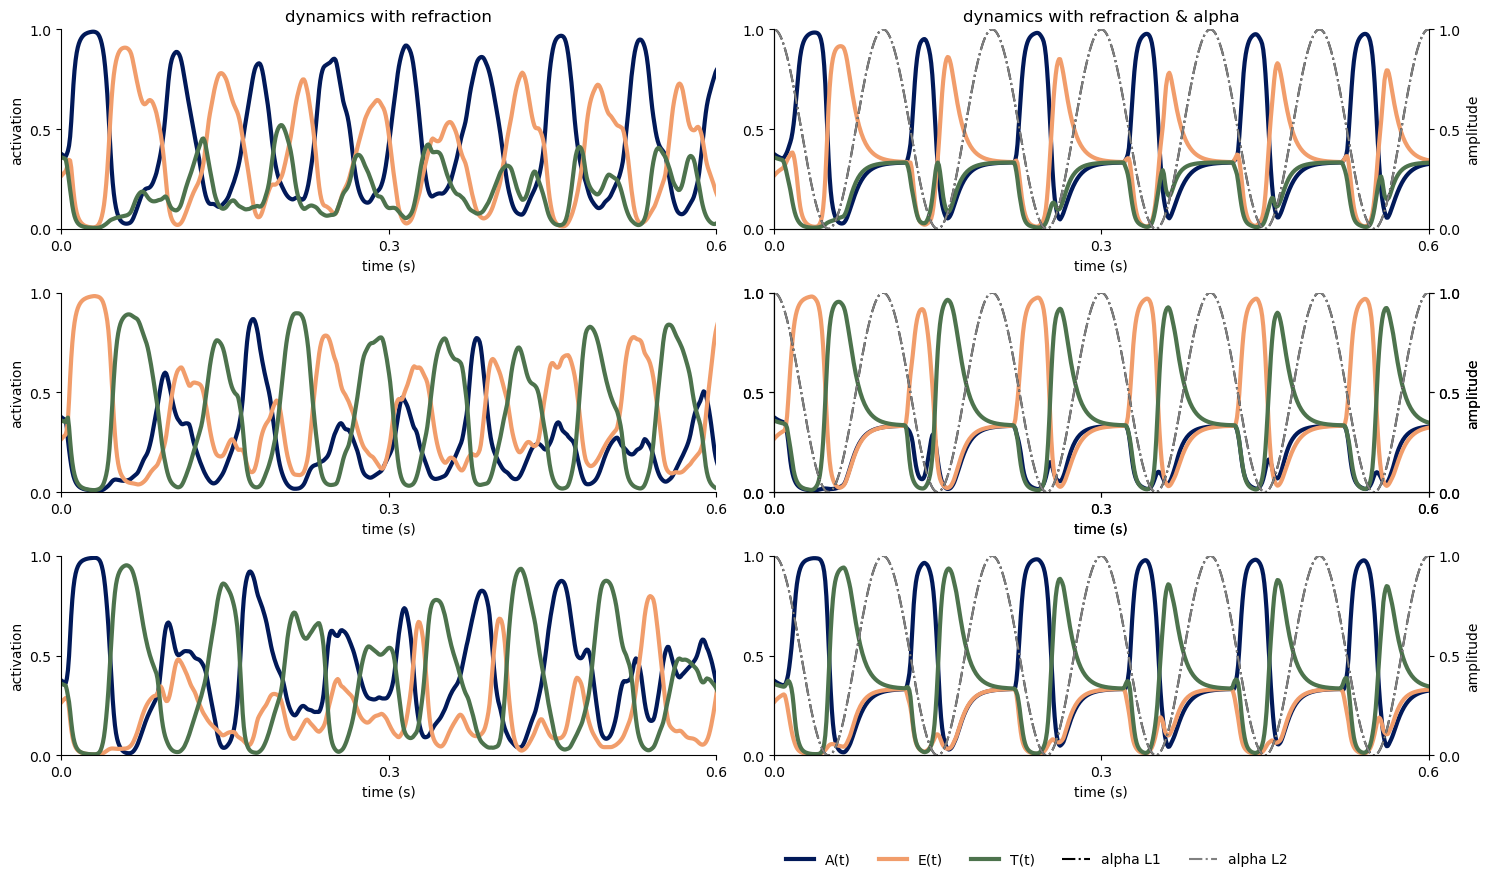

In [23]:
# PLOT

# prepare layout
from aet_figures import fig6

# make a gridplot for all 3 combinations with and without alpha
fig_6 = fig6(timevec, t, alpha_params, OtEA, OtaEA, OtET, OtaET, OtAT, OtaAT)

fig_6.savefig(fig_pth + "fig6_two_inputs.svg")

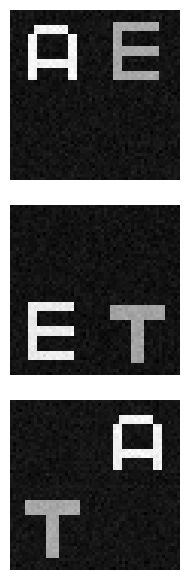

In [24]:
# plot stimulus examples
fig, axs = plt.subplots(3, 1, figsize=(2, 6))

for i, _im in enumerate(inpt):
    axs[i].imshow(_im.reshape(56, 56), cmap="gray")
    axs[i].set_axis_off()

fig.tight_layout()

fig.savefig(fig_pth + "sim_stim_noise.svg")

In [25]:
torch.max(Ot).numpy()

array(0.9867863, dtype=float32)

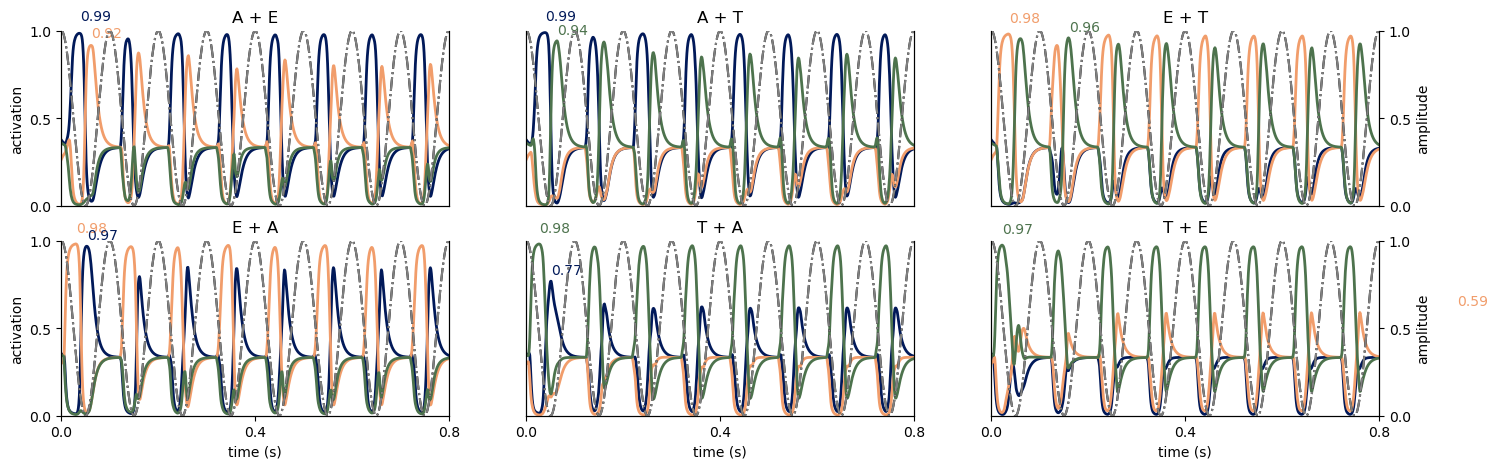

In [26]:
# try other combinations of inputs

t_start = 0  # when stimulus presented
t = 0  # when to begin plot
start_fix_z = maxZ / 4
params = [tau_h, tau_R, c, S]

# alpha parameters
afreq = [10, 10]
aamp = [0.5, 0.5]
aph = [np.pi / 2, np.pi / 2]  # [np.pi+2*np.pi/100 * 10,np.pi]

alpha_params = [afreq, aamp, aph]

timevec = np.linspace(0, 1, 1000)

idx = np.array((0, 5, 11))  # ,-1))


labels = ["A", "E", "T"]

from aet_figures import supp_fig1

supp_fig_1, qu_acc = supp_fig1(
    x_test, model, timevec, t_start, t, params, alpha_params, idx, labels, start_fix_z, noise=add_noise
)

supp_fig_1.savefig(fig_pth + "supp1_code_allcomb.svg")

In [27]:
qu_acc

array([[0.99000001, 0.92000002],
       [0.99000001, 0.94      ],
       [0.98000002, 0.97000003],
       [0.98000002, 0.76999998],
       [0.97000003, 0.58999997],
       [0.        , 0.        ]])

In [28]:
timevec = np.linspace(0,1,1000)
test = torch.arange(1000)
timevec[np.argmax(test[:800].numpy())]

0.7997997997997998

### Phase delay between layers

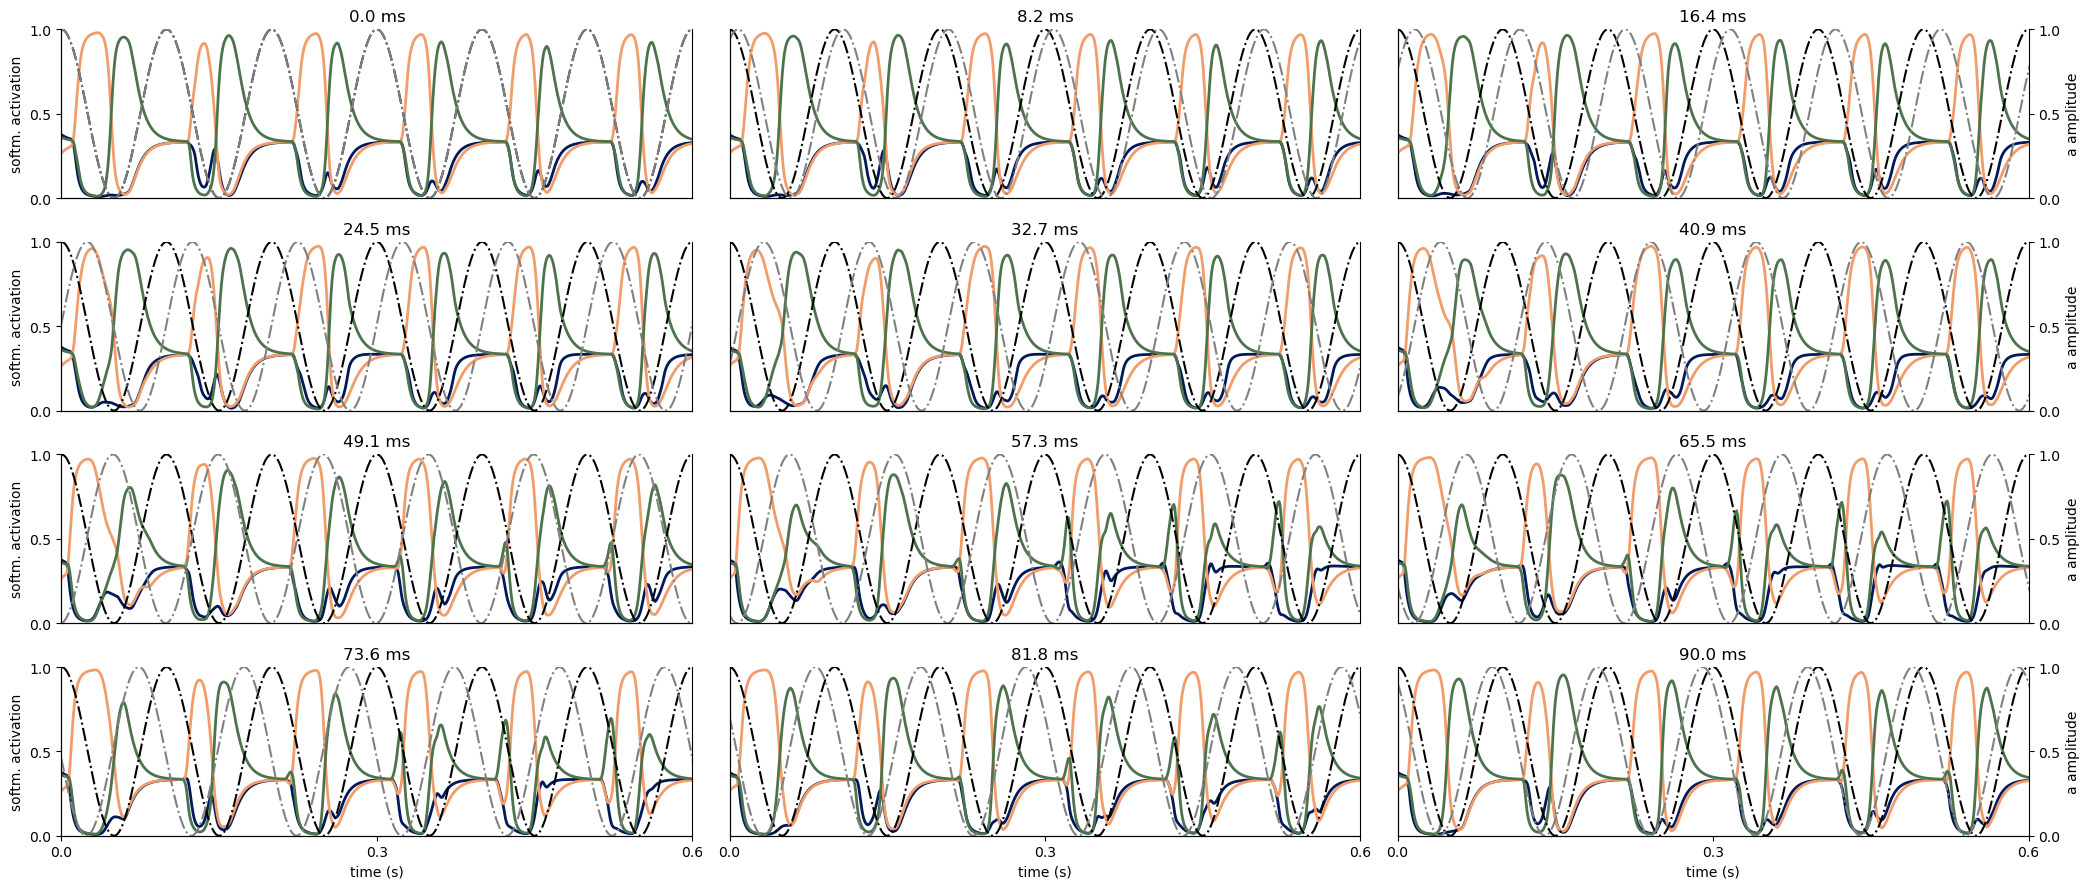

In [29]:
idx_stim = [5, -1]

ph_diff = np.linspace(0, 2 * np.pi - (2 * np.pi / 100) * 10, 12)

# Dynamics two inputs

t_start = 0  # when stimulus presented
t = 0  # when to begin plot

params = [tau_h, tau_R, c, S]

# alpha parameters
afreq = [10, 10]
aamp = [0.5, 0.5]

alpha_params = [afreq, aamp]

from aet_figures import fig8

fig_8 = fig8(
    timevec, t_start, t, inpt[1], model, params, alpha_params, ph_diff, start_fix_z
)
fig_8.savefig(fig_pth + "fig8_phase_diff.svg")

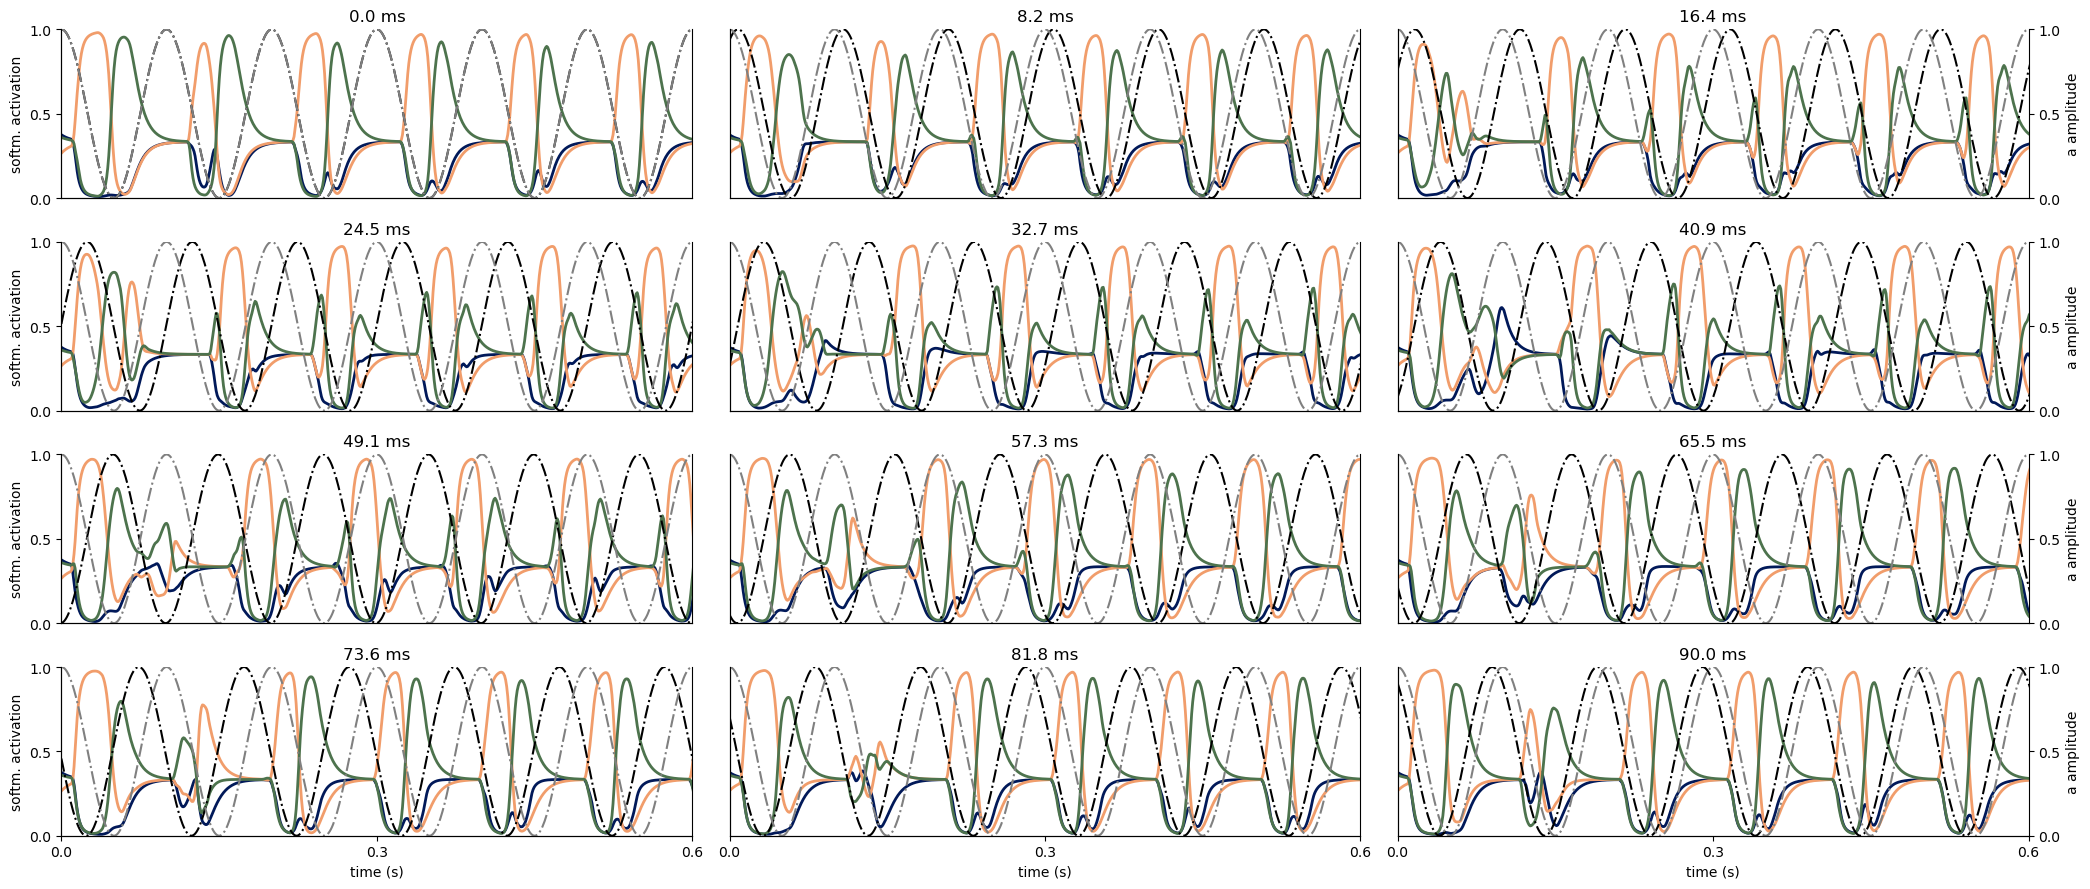

In [30]:

from aet_figures import supp_fig5

supp_fig_5 = supp_fig5(
    timevec, t_start, t, inpt[1], model, params, alpha_params, ph_diff, start_fix_z
)
supp_fig_5.savefig(fig_pth + "supp_fig5_phase_diff.svg")

### Segregation/Multiplexing along layers

In [31]:
x_test_noise, _ = aet_net_2lay.aet_stim.mkstim(noise=add_noise, num_it=0)
x_test_noise = x_test_noise.to(DEVICE)

In [32]:
# get non-dynamic activation for hidden representations
_, H1, H2, O = model.forw_conv(x_test_noise)

t_start = 0  # when stimulus presented
t = 0  # when to begin plot

params = [tau_h, tau_R, c, S]

# alpha parameters
afreq = [10, 10]
aamp = [0.5, 0.5]
aph = [np.pi / 2, np.pi / 2]  # [np.pi+2*np.pi/100 * 10,np.pi]]

alpha_params = [afreq, aamp, aph]

Z1t, Z2t, H1t, R1t, H2t, R2t, Ot = euler_dyn_2layer(
    model,
    inpt[1],
    params,
    timevec,
    alpha_params,
    DEVICE,
    inp_on=t_start,
    start_fix=start_fix_z,
)

# normalized dot product to track similarity to single input

# Layer 1

H1corrA = np.array(
    [
        (torch.dot(H1t[:, t], H1[0]) / torch.dot(H1[0], H1[0])).detach().numpy()
        for t in range(H1t.shape[1])
    ]
)
H1corrE = np.array(
    [
        (torch.dot(H1t[:, t], H1[5]) / torch.dot(H1[5], H1[5])).detach().numpy()
        for t in range(H1t.shape[1])
    ]
)
H1corrT = np.array(
    [
        (torch.dot(H1t[:, t], H1[-1]) / torch.dot(H1[-1], H1[-1])).detach().numpy()
        for t in range(H1t.shape[1])
    ]
)


# Layer 2

H2corrA = np.array(
    [
        (torch.dot(H2t[:, t], H2[0]) / torch.dot(H2[0], H2[0])).detach().numpy()
        for t in range(H2t.shape[1])
    ]
)
H2corrE = np.array(
    [
        (torch.dot(H2t[:, t], H2[5]) / torch.dot(H2[5], H2[5])).detach().numpy()
        for t in range(H2t.shape[1])
    ]
)
H2corrT = np.array(
    [
        (torch.dot(H2t[:, t], H2[-1]) / torch.dot(H2[-1], H2[-1])).detach().numpy()
        for t in range(H2t.shape[1])
    ]
)

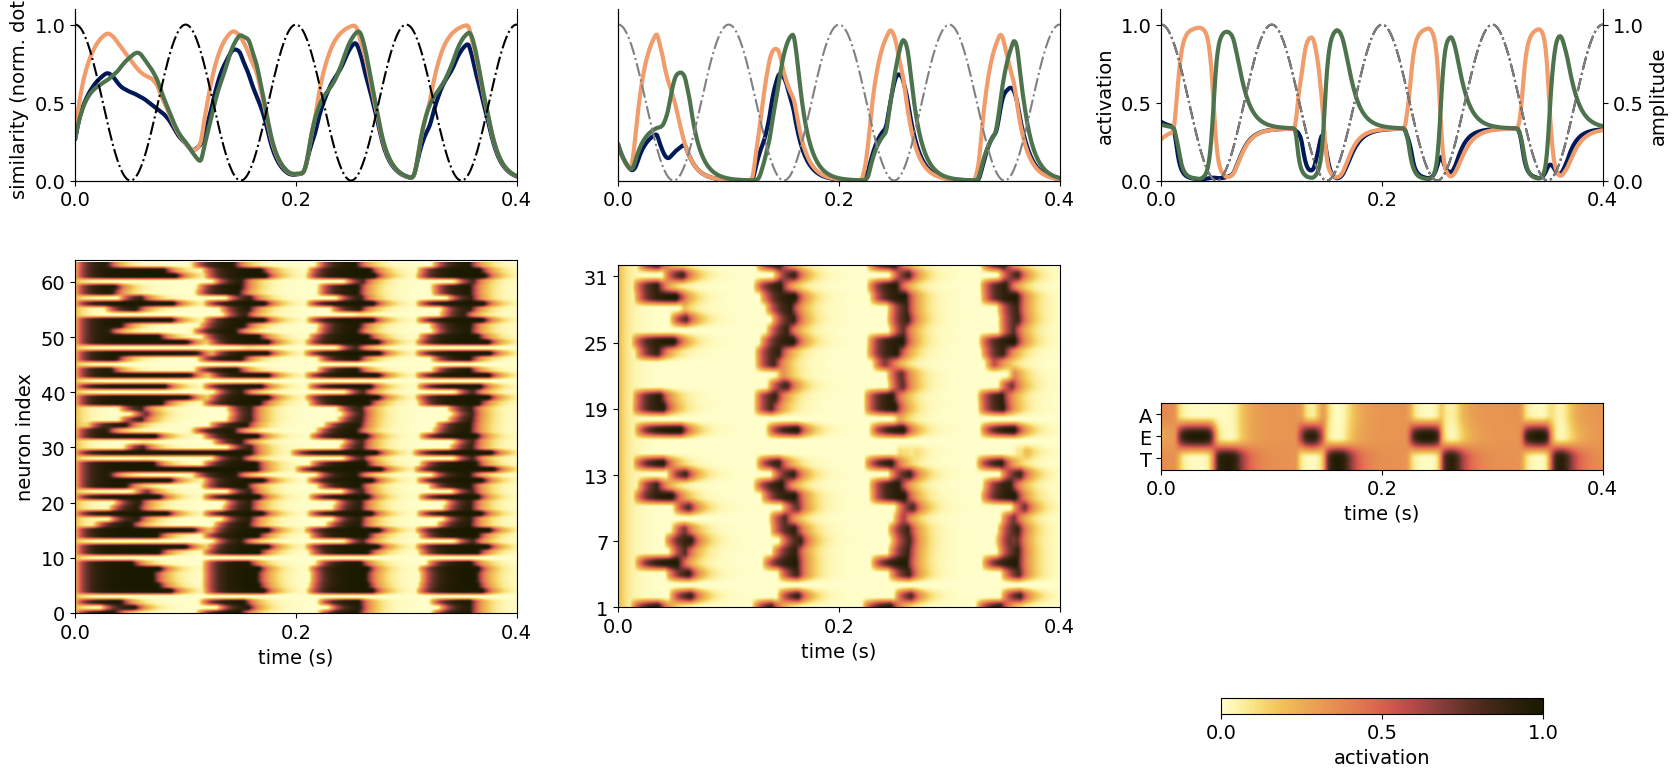

In [33]:
from aet_figures import fig7

fig_7 = fig7(
    timevec,
    t,
    alpha_params,
    H1corrA,
    H1corrE,
    H1corrT,
    H1t,
    H2corrA,
    H2corrE,
    H2corrT,
    H2t,
    Ot,
)

fig_7.savefig(fig_pth + "fig7_segr_layers.svg")

### Speed up dynamics

In [34]:
# Dynamics parameters
tau_R = 0.05

t_start = 0  # when stimulus presented
t = 0  # when to begin plot

params = [tau_h, tau_R, c, S]

# parameters for integration
timevec = np.linspace(0, 1, 1000)

t_start = 0  # when stimulus presented
t = 0  # when to begin plot

params = [tau_h, tau_R, c, S]

inpt = [None] * 3
# E & A
inpt[0] = (x_test[5] * 0.8 + x_test[0] * 1.2 + torch.normal(0.4, 0.1, x_test[5].shape) * 0.3)
inpt[0] /= torch.max(inpt[0])

# without alpha
aamp = [0, 0]


alpha_params = [afreq, aamp, aph]

# time course of output for E & A
OtEA = euler_dyn_2layer(
    model, inpt[0], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]


# with alpha
aamp = [0.5, 0.5]

alpha_params = [afreq, aamp, aph]

OtaEA = euler_dyn_2layer(
    model, inpt[0], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]


# E & T
inpt[1] = (x_test[6] * 1.2 + x_test[-1] * 0.8 + torch.normal(0.4, 0.1, x_test[5].shape) * 0.3)
inpt[1] /= torch.max(inpt[1])
# without alpha
aamp = [0, 0]


alpha_params = [afreq, aamp, aph]

OtET = euler_dyn_2layer(
    model, inpt[1], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]


# with alpha
aamp = [0.5, 0.5]

alpha_params = [afreq, aamp, aph]

OtaET = euler_dyn_2layer(
    model, inpt[1], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]

# A & T
inpt[2] = (x_test[0] * 1.2 + x_test[-1] * 0.8 + torch.normal(0.4, 0.1, x_test[5].shape) * 0.3)
inpt[2] /= torch.max(inpt[2])

# without alpha
aamp = [0, 0]

alpha_params = [afreq, aamp, aph]

OtAT = euler_dyn_2layer(
    model, inpt[2], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]


# with alpha
aamp = [0.5, 0.5]

alpha_params = [afreq, aamp, aph]

OtaAT = euler_dyn_2layer(
    model, inpt[2], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]

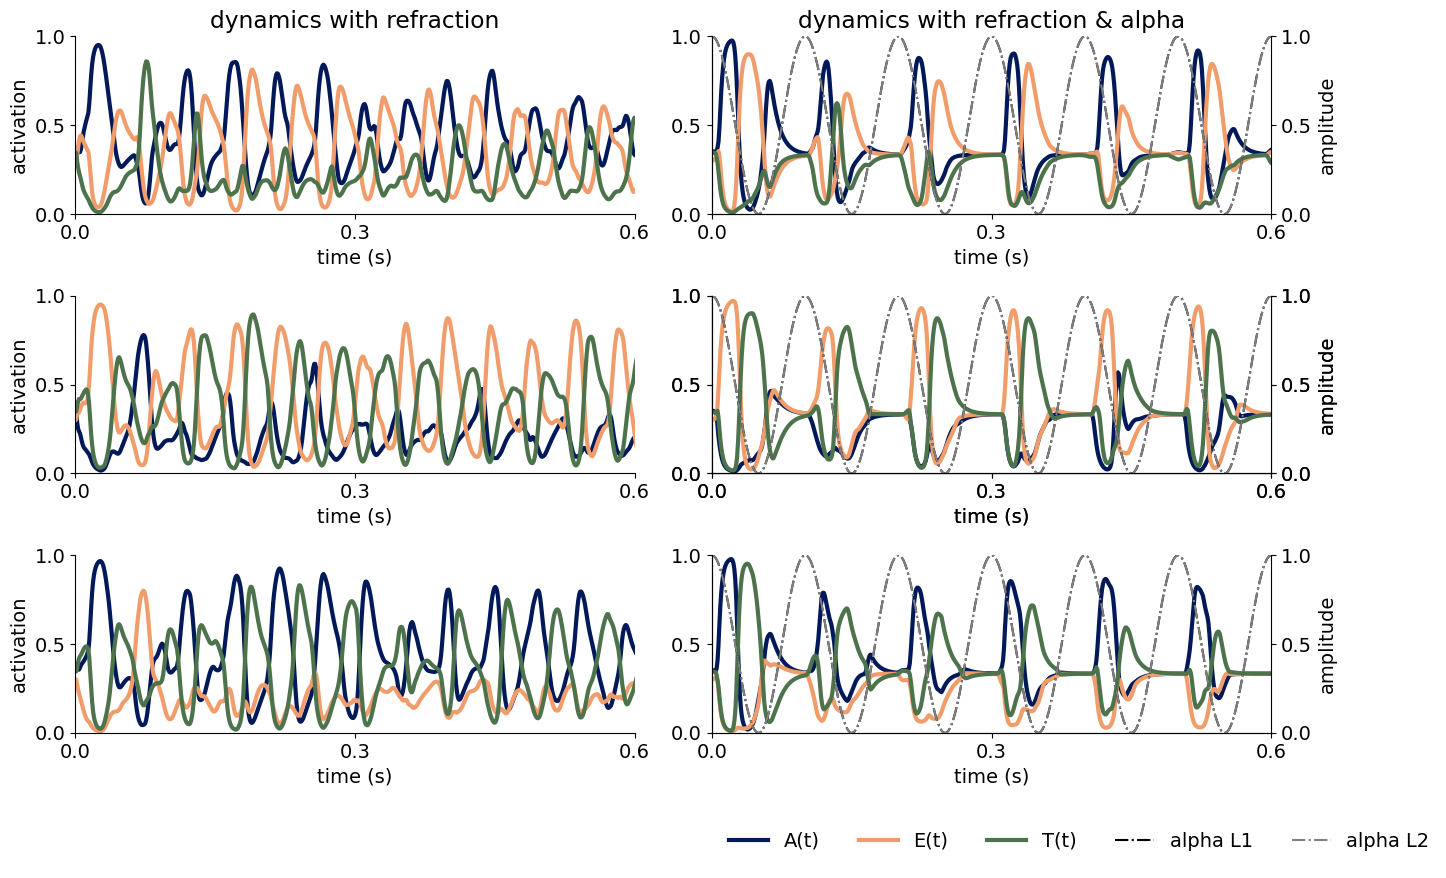

In [35]:
fig_6 = fig6(timevec, t, alpha_params, OtEA, OtaEA, OtET, OtaET, OtAT, OtaAT)
fig_6.savefig(fig_pth + "supp2_faster_dyn.svg")

### Slow down inhibition

In [36]:
# Dynamics parameters
t_start = 0  # when stimulus presented
t = 0  # when to begin plot
tau_R = 0.1
params = [tau_h, tau_R, c, S]

# parameters for integration
timevec = np.linspace(0, 1, 1000)


# E & A

# without alpha
aamp = [0, 0]


alpha_params = [afreq, aamp, aph]

# time course of output for E & A
OtEA = euler_dyn_2layer(
    model, inpt[0], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]


# with alpha
afreq = [5, 5]
aamp = [0.5, 0.5]
aph = [np.pi / 2, np.pi / 2]
alpha_params = [afreq, aamp, aph]

OtaEA = euler_dyn_2layer(
    model, inpt[0], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]


# E & T

# without alpha
aamp = [0, 0]


alpha_params = [afreq, aamp, aph]

OtET = euler_dyn_2layer(
    model, inpt[1], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]


# with alpha
aamp = [0.5, 0.5]

alpha_params = [afreq, aamp, aph]

OtaET = euler_dyn_2layer(
    model, inpt[1], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]

# A & T


# without alpha
aamp = [0, 0]

alpha_params = [afreq, aamp, aph]

OtAT = euler_dyn_2layer(
    model, inpt[2], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]


# with alpha
aamp = [0.5, 0.5]

alpha_params = [afreq, aamp, aph]

OtaAT = euler_dyn_2layer(
    model, inpt[2], params, timevec, alpha_params, DEVICE, t_start, start_fix=True
)[-1]

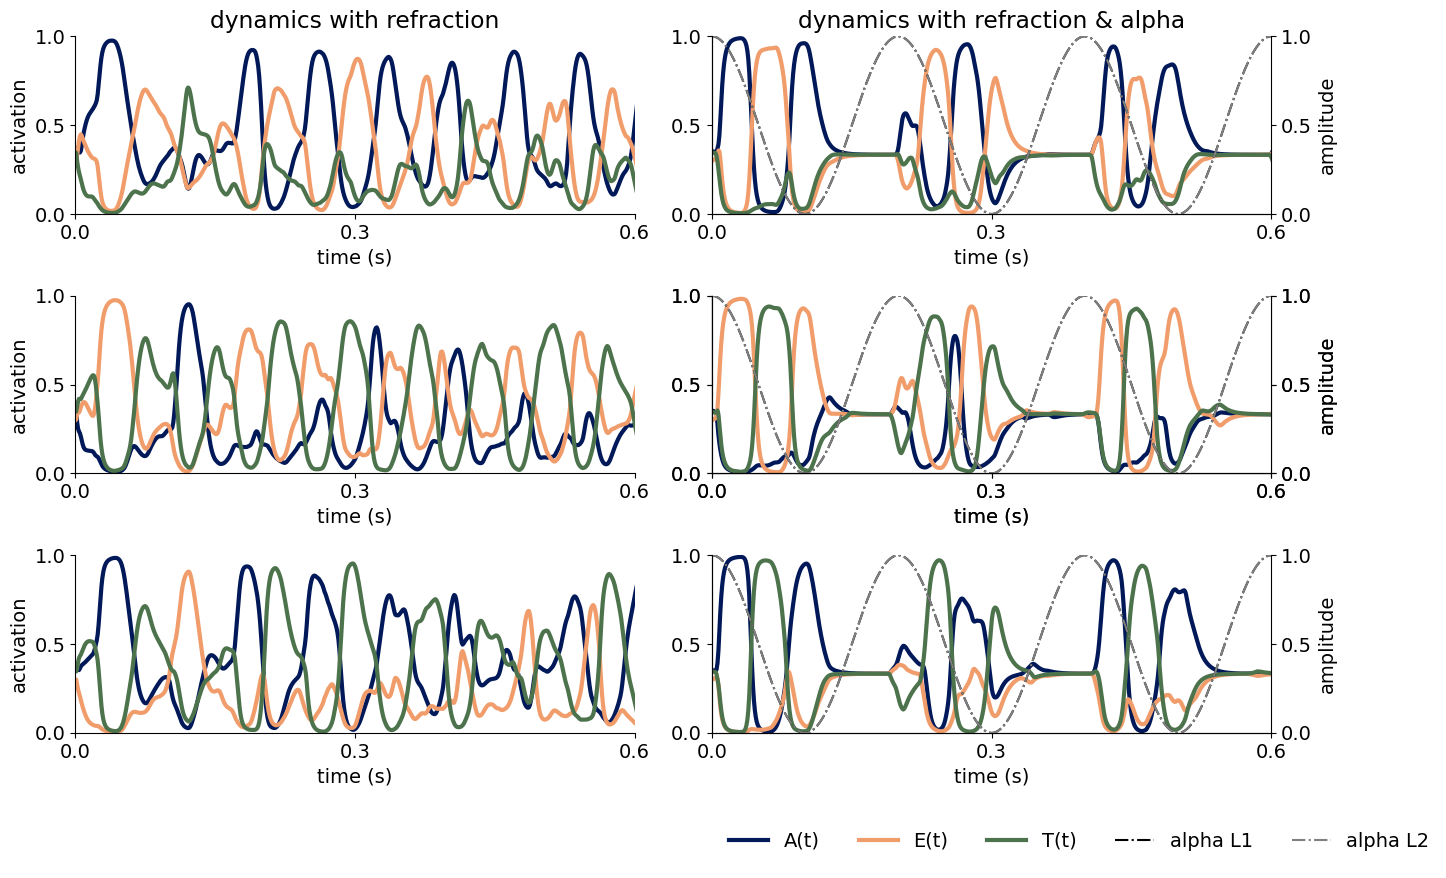

In [37]:
fig_6 = fig6(timevec, t, alpha_params, OtEA, OtaEA, OtET, OtaET, OtAT, OtaAT)
fig_6.savefig(fig_pth + "supp3_slower_inh.svg")

### 3 simultanous stimuli

In [38]:
x_test, _ = aet_net_2lay.aet_stim.mkstim(noise=False)
x_test = x_test.to(DEVICE)

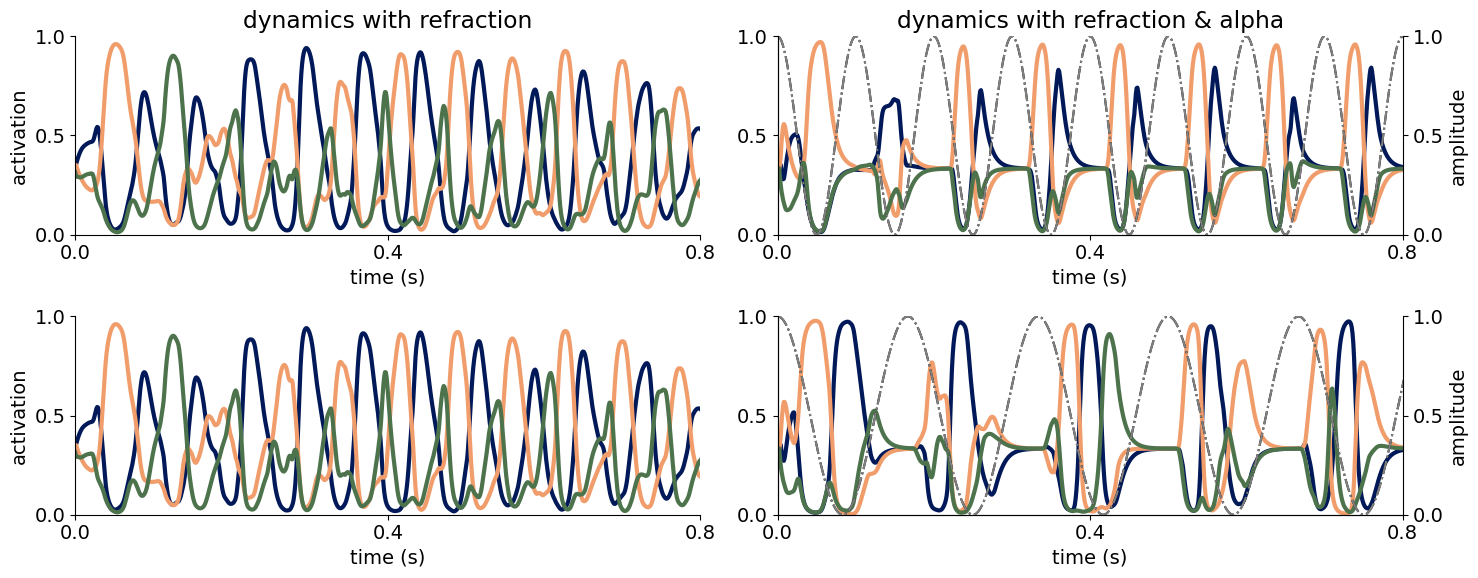

In [39]:
# Dynamics parameters
params = [tau_h, tau_R, c, S]

# parameters for integration
timevec = np.linspace(0, 1, 1000)

params = [tau_h, tau_R, c, S]

inpt = (
    x_test[5] * 1.4
    + x_test[0] * 1.0
    + x_test[-1] * 0.6
    + torch.normal(0.4, 0.1, x_test[5].shape) * 0.3)

inpt /= torch.max(inpt)

start_fix_z = torch.max(inpt) / 5

# without alpha

afreq = [10, 10]
aamp = [0, 0]
aph = [np.pi / 2, np.pi / 2]  # phase lag = 0 between layers


alpha_params = [afreq, aamp, aph]

# time course of output for E & A
Ot3slow = euler_dyn_2layer(
    model, inpt, params, timevec, alpha_params, DEVICE, t_start, start_fix=start_fix_z
)[-1]


# with alpha
aamp = [0.5, 0.5]


alpha_params_og = [afreq, aamp, aph]

Ota3slow = euler_dyn_2layer(
    model,
    inpt,
    params,
    timevec,
    alpha_params_og,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)[-1]

# without alpha
aamp = [0, 0]


alpha_params = [afreq, aamp, aph]

# time course of output for E & A
Ot3fast = euler_dyn_2layer(
    model, inpt, params, timevec, alpha_params, DEVICE, t_start, start_fix=start_fix_z
)[-1]


# with alpha

afreq = [6, 6]
aamp = [0.5, 0.5]

alpha_params_new = [afreq, aamp, aph]

Ota3fast = euler_dyn_2layer(
    model,
    inpt,
    params,
    timevec,
    alpha_params_new,
    DEVICE,
    t_start,
    start_fix=start_fix_z,
)[-1]


from aet_figures import supp_fig4

supp_fig_4 = supp_fig4(
    timevec, t, alpha_params_og, alpha_params_new, Ot3slow, Ota3slow, Ot3fast, Ota3fast
)

supp_fig_4.savefig(fig_pth + "fig9_3stim.svg")

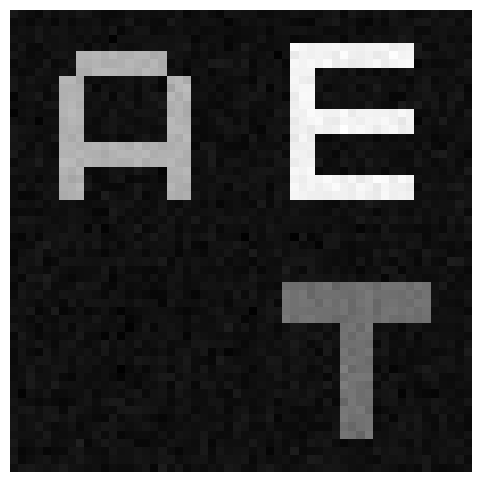

In [40]:
fig, axs = plt.subplots()
axs.imshow(inpt.reshape(56, 56), cmap="gray")
axs.set_axis_off()
fig.savefig(fig_pth + "inp_3stim.svg")